In [1]:
import os
import zarr
import timm
import random
import json
import gc
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict

import sys
import torch
from torch.cuda.amp import autocast, GradScaler

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from tqdm import tqdm
from src.kaggle_notebook_metric import compute_lb, extract_particle_results
from src.inference import inference, inference2pos, create_gt_df
from metric import visualize_epoch_results

import wandb
from pathlib import Path

notebook_name = os.path.join(Path().resolve()).split("/")[-1]

param = {
    "model": CFG.model_name,
    "resolution": CFG.resolution,
    "augmentation_prob": CFG.augmentation_prob,
    "slice": CFG.slice_,
    "epochs": CFG.epochs,
    "lr": CFG.lr,
    "batch_size": CFG.batch_size,
    "weight_decay": CFG.weight_decay,
    "num_workers": CFG.num_workers,
    "augment_data_ratio": CFG.augment_data_ratio,
}

In [2]:
from sklearn.metrics import *
from scipy.optimize import minimize

# sikii値とexp_namesを入れるとスコアを出力する関数


def compute_score(sikii_list, inferenced_array, exp_name):
    apo_ferritin = sikii_list[0]
    beta_amylase = sikii_list[1]
    beta_galactosidase = sikii_list[2]
    ribosome = sikii_list[3]
    thyroglobulin = sikii_list[4]
    virus_like_particle = sikii_list[5]

    sikii_dict = {
        "apo-ferritin": apo_ferritin,
        "beta-amylase": beta_amylase,
        "beta-galactosidase": beta_galactosidase,
        "ribosome": ribosome,
        "thyroglobulin": thyroglobulin,
        "virus-like-particle": virus_like_particle,
    }

    all_pred = []

    pred_df = inference2pos(
        pred_segmask=inferenced_array, exp_name=exp_name, sikii_dict=sikii_dict
    )

    all_pred.append(pred_df)

    gc.collect()

    pred_df = pd.concat(all_pred, axis=0).reset_index(drop=True)
    pred_df = pred_df[pred_df["particle_type"] != "beta-amylase"]
    pred_df = pred_df.drop_duplicates(
        subset=["experiment", "x", "y", "z"], keep="first"
    ).reset_index(drop=True)
    pred_df = pred_df.reset_index().rename(columns={"index": "id"})

    gt_df = create_gt_df("../../inputs/train/overlay/ExperimentRuns/", [exp_name])

    result_df, lb_score = compute_lb(
        pred_df, "../../inputs/train/overlay/ExperimentRuns/", [exp_name]
    )

    return lb_score


def reduce_computation_sikii_search(
    inferenced_array: np.ndarray, exp_name: str, threshold_candidates: list[float]
) -> tuple[list[float], float]:
    """
    # How
    6つのしきい値が互いに独立してスコアに貢献しているという前提で、
    1次元ずつ最適なしきい値を探す手法を実装する.

    1. 初期の best_thresholds (全要素 0.5 など適当な値) を用意
    2. i=0 から i=5 まで順番に:
       - threshold_candidates をすべて試し、他は固定したまま i 番目だけ変化させてスコアを計算
       - 最良スコアが得られる候補値を確定し、best_thresholds[i] とする
    3. 全部決まったら最終的なスコアを計算して返す

    これにより、全組み合わせ (product) を回すよりも計算量が大幅に減少する.
    """
    # Why not: 6値独立であるという前提が満たされていない場合、近似解になる可能性あり
    best_thresholds = [0.5] * 6  # 適当な初期値でOK

    for i in tqdm(range(6)):
        best_local_score = -float("inf")
        best_local_value = None

        for candidate in threshold_candidates:
            current_thresholds = best_thresholds[:]  # 現在のベストを複製
            current_thresholds[i] = candidate
            score = compute_score(current_thresholds, inferenced_array, exp_name)
            if score > best_local_score:
                best_local_score = score
                best_local_value = candidate

        # i番目のしきい値を最適値に更新
        best_thresholds[i] = best_local_value

    final_score = compute_score(best_thresholds, inferenced_array, exp_name)
    return best_thresholds, final_score

In [3]:
import torch
import random
import torchvision.transforms.functional as TF


# 回転
# 3Dテンソルの各軸に対して指定した角度で回転する関数
def rotate_3d(tomogram, segmentation_map, angle):
    """Rotates the 3D tensors tomogram and segmentation_map around the Z-axis."""
    rotated_tomogram = TF.rotate(tomogram, angle, expand=False)
    rotated_segmentation_map = TF.rotate(segmentation_map, angle, expand=False)
    return rotated_tomogram, rotated_segmentation_map


# 平行移動
# 指定された範囲でランダムに平行移動
def translate_3d(tomogram, segmentation_map, max_shift):
    """Translates the 3D tensors by a random shift within max_shift."""
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    translated_tomogram = TF.affine(
        tomogram, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    translated_segmentation_map = TF.affine(
        segmentation_map, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    return translated_tomogram, translated_segmentation_map


# フリップ
# 縦横（上下左右）ランダムフリップ
def flip_3d(tomogram, segmentation_map):
    """Randomly flips the 3D tensors along height or width."""
    if random.random() > 0.5:  # Horizontal flip
        tomogram = torch.flip(tomogram, dims=[-1])
        segmentation_map = torch.flip(segmentation_map, dims=[-1])
    if random.random() > 0.5:  # Vertical flip
        tomogram = torch.flip(tomogram, dims=[-2])
        segmentation_map = torch.flip(segmentation_map, dims=[-2])
    return tomogram, segmentation_map


# クロッピング
# 入力テンソルを中心またはランダムクロップで切り取る
def crop_3d(tomogram, segmentation_map, crop_size):
    """Crops the 3D tensors to the specified crop_size."""
    _, depth, height, width = tomogram.size()
    crop_d, crop_h, crop_w = crop_size

    if crop_h > height or crop_w > width:
        raise ValueError("Crop size cannot be larger than the original size.")

    start_h = random.randint(0, height - crop_h)  # Random starting position for height
    start_w = random.randint(0, width - crop_w)  # Random starting position for width

    cropped_tomogram = tomogram[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]
    cropped_segmentation_map = segmentation_map[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]

    return cropped_tomogram, cropped_segmentation_map


# Mixup
# 2つのサンプルを線形補間して混合
def mixup(tomogram, segmentation_map, alpha=0.4):
    """Applies mixup augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size = tomogram.size(0)
    index = torch.randperm(batch_size)

    mixed_tomogram = lam * tomogram + (1 - lam) * tomogram[index, :]
    mixed_segmentation_map = (
        lam * segmentation_map + (1 - lam) * segmentation_map[index, :]
    )

    return mixed_tomogram, mixed_segmentation_map


# Cutmix
# ランダム領域を切り取って別のサンプルに貼り付け
def cutmix(tomogram, segmentation_map, alpha=1.0):
    """Applies cutmix augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size, depth, height, width = tomogram.size()
    index = torch.randperm(batch_size)

    cx = random.randint(0, width)
    cy = random.randint(0, height)
    cw = int(width * (1 - lam))
    ch = int(height * (1 - lam))

    x1 = max(cx - cw // 2, 0)
    x2 = min(cx + cw // 2, width)
    y1 = max(cy - ch // 2, 0)
    y2 = min(cy + ch // 2, height)

    tomogram[:, :, y1:y2, x1:x2] = tomogram[index, :, y1:y2, x1:x2]
    segmentation_map[:, :, y1:y2, x1:x2] = segmentation_map[index, :, y1:y2, x1:x2]

    return tomogram, segmentation_map


# データ拡張の組み合わせ適用
def augment_data(
    tomogram,
    segmentation_map,
    crop_size=(16, 256, 256),
    max_shift=10,
    rotation_angle=30,
    p=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
):
    """Applies a combination of rotation, translation, flipping, cropping, mixup, and cutmix to the inputs with probabilities."""
    if random.random() < p:
        tomogram, segmentation_map = rotate_3d(
            tomogram,
            segmentation_map,
            angle=random.uniform(-rotation_angle, rotation_angle),
        )
    if random.random() < p:
        tomogram, segmentation_map = translate_3d(
            tomogram, segmentation_map, max_shift=max_shift
        )
    if random.random() < p:
        tomogram, segmentation_map = flip_3d(tomogram, segmentation_map)
    if random.random() < p:
        tomogram, segmentation_map = crop_3d(
            tomogram, segmentation_map, crop_size=crop_size
        )
    # if random.random() < p:
    #     tomogram, segmentation_map = mixup(
    #         tomogram, segmentation_map, alpha=mixup_alpha
    #     )
    # if random.random() < p:
    #     tomogram, segmentation_map = cutmix(
    #         tomogram, segmentation_map, alpha=cutmix_alpha
    #     )
    return tomogram, segmentation_map


# 使用例
# バッチサイズ6, 深さ16, 高さ320, 幅320のランダムテンソル
tomogram = torch.rand((6, 16, 320, 320))
segmentation_map = torch.randint(0, 2, (6, 16, 320, 320))  # ラベルは0または1

# データ拡張の適用
aug_tomogram, aug_segmentation_map = augment_data(tomogram, segmentation_map, p=0.7)
print("Original shape:", tomogram.shape)
print("Augmented shape:", aug_tomogram.shape)

Original shape: torch.Size([6, 16, 320, 320])
Augmented shape: torch.Size([6, 16, 256, 256])


In [4]:
from transformers import get_cosine_schedule_with_warmup

In [5]:
# b, c, d, h, w = CFG.batch_size, 1, 96, 320, 320

In [6]:
def preprocess_tensor(tensor):
    batch_size, depth, height, width = tensor.shape
    tensor = tensor.unsqueeze(2)  # (b, d, h, w) -> (b, d, 1, h, w)
    return tensor


padf = PadToSize(CFG.resolution)

In [7]:
for train_exp_name in ["TS_73_6", "TS_99_9", "TS_6_4", "TS_69_2", "TS_86_3", "TS_6_6"]:
    wandb.init(
        project="czii2024", name=f"{notebook_name}_{train_exp_name}", config=param
    )

    # vaild_exp_name = [vaild_exp_name]
    # train_exp_name = CFG.train_exp_names.copy()
    # train_exp_name.remove(vaild_exp_name[0])

    prime_train_exp_name = train_exp_name
    valid_exp_name = ["TS_73_6", "TS_99_9", "TS_6_4", "TS_69_2", "TS_86_3", "TS_6_6"]
    valid_exp_name.remove(train_exp_name)

    print("train_exp_name", train_exp_name)
    print("valid_exp_name", valid_exp_name)

    train_exp_name = CFG.train_exp_names.copy()

    for v in valid_exp_name:
        train_exp_name.remove(v)

    # valid_exp_name[0]の名前でディレクトリを作成
    os.makedirs(f"./{prime_train_exp_name}", exist_ok=True)

    train_dataset = EziiDataset(
        exp_names=train_exp_name,
        base_dir="../../inputs/train/",
        particles_name=CFG.particles_name,
        resolution=CFG.resolution,
        zarr_type=CFG.train_zarr_types,
        train=True,
        augmentation=True,
        slice=True,
        pre_read=True,
    )
    valid_dataset = EziiDataset(
        exp_names=valid_exp_name,
        base_dir="../../inputs/train/",
        particles_name=CFG.particles_name,
        resolution=CFG.resolution,
        zarr_type=CFG.valid_zarr_types,
        augmentation=False,
        train=True,
        slice=True,
        pre_read=True,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        drop_last=True,
        pin_memory=True,
        num_workers=CFG.num_workers,
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
        num_workers=CFG.num_workers,
    )

    encoder = timm.create_model(
        model_name=CFG.model_name,
        pretrained=True,
        in_chans=3,
        num_classes=0,
        global_pool="",
        features_only=True,
    )
    model = Unet3D(encoder=encoder, num_domains=5).to("cuda")

    optimizer = torch.optim.Adam(
        model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
    )
    criterion = DiceLoss()
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=10,
        num_training_steps=CFG.epochs * len(train_loader),
        # * batch_size,
    )
    scaler = GradScaler()
    seg_loss = SegmentationLoss(criterion)
    padf = PadToSize(CFG.resolution)

    best_model = None
    best_constant = 0
    best_score = -100
    best_particle_score = {}

    grand_train_loss = []
    grand_valid_loss = []
    grand_train_score = []
    grand_valid_score = []

    for epoch in range(CFG.epochs):
        model.train()
        train_loss = []
        valid_loss = []
        with tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Training]"
        ) as tq:
            for data in tq:
                normalized_tomogram = data["normalized_tomogram"]
                segmentation_map = data["segmentation_map"]
                zarr_embedding_idx = data["zarr_type_embedding_idx"]

                normalized_tomogram = padf(normalized_tomogram)
                segmentation_map = padf(segmentation_map)

                # データ拡張
                normalized_tomogram, segmentation_map = augment_data(
                    normalized_tomogram, segmentation_map, p=CFG.augmentation_prob
                )
                normalized_tomogram = normalized_tomogram.cuda()
                segmentation_map = segmentation_map.long().cuda()
                zarr_embedding_idx = zarr_embedding_idx.cuda()

                optimizer.zero_grad()

                with autocast():
                    pred = model(
                        preprocess_tensor(normalized_tomogram), zarr_embedding_idx
                    )
                    loss = seg_loss(pred, segmentation_map)
                # loss.backward()
                # optimizer.step()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                train_loss.append(loss.item())

                # 確率予測
                prob_pred = torch.softmax(pred, dim=1)
                tq.set_postfix({"loss": f"{np.mean(train_loss):.4f}"})

        del normalized_tomogram, segmentation_map, zarr_embedding_idx, pred, loss
        gc.collect()
        torch.cuda.empty_cache()

        with tqdm(
            valid_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Validation]"
        ) as tq:
            with torch.no_grad():
                for data in tq:
                    normalized_tomogram = data["normalized_tomogram"].cuda()
                    segmentation_map = data["segmentation_map"].long().cuda()
                    zarr_embedding_idx = data["zarr_type_embedding_idx"].cuda()

                    normalized_tomogram = padf(normalized_tomogram)
                    segmentation_map = padf(segmentation_map)

                    with autocast():
                        pred = model(
                            preprocess_tensor(normalized_tomogram), zarr_embedding_idx
                        )
                        loss = seg_loss(pred, segmentation_map)
                    valid_loss.append(loss.item())

                    # 確率予測
                    prob_pred = torch.softmax(pred, dim=1)
                    tq.set_postfix({"loss": f"{np.mean(valid_loss):.4f}"})

        del normalized_tomogram, segmentation_map, zarr_embedding_idx, pred, loss
        gc.collect()
        torch.cuda.empty_cache()

        # # ############### validation ################
        train_nshuffle_original_tomogram = defaultdict(list)
        train_nshuffle_pred_tomogram = defaultdict(list)
        train_nshuffle_gt_tomogram = defaultdict(list)

        valid_original_tomogram = defaultdict(list)
        valid_pred_tomogram = defaultdict(list)
        valid_gt_tomogram = defaultdict(list)

        train_mean_scores = []
        valid_mean_scores = []

        # モデルの保存
        make_dir_ = (
            f"../../../../../../../../mnt/d/kaggle-tmp-models/czii2024/{notebook_name}/"
        )
        os.makedirs(make_dir_, exist_ok=True)
        torch.save(model.state_dict(), make_dir_ + f"model_{epoch}.pth")

        # ############### validation ################
        train_nshuffle_original_tomogram = defaultdict(list)
        train_nshuffle_pred_tomogram = defaultdict(list)
        train_nshuffle_gt_tomogram = defaultdict(list)

        valid_original_tomogram = defaultdict(list)
        valid_pred_tomogram = defaultdict(list)
        valid_gt_tomogram = defaultdict(list)

        train_mean_scores = []
        valid_mean_scores = []

        train_inferenced_array = {}
        train_pred_array = []
        train_gt_array = []
        valid_inferenced_array = {}
        valid_gt_array = []

        # for exp_name in tqdm(CFG.train_exp_names):
        for exp_name in valid_exp_name:  # 5つのデータで試す
            # inferenced_array = inference(model, exp_name, train=False)
            inferenced_array, n_tomogram, segmentation_map = inference(
                model, exp_name, train=False
            )
            valid_inferenced_array[exp_name] = inferenced_array
            base_dir = "../../inputs/train/overlay/ExperimentRuns/"
            gt_df = create_gt_df(base_dir, [exp_name])
            valid_gt_array.append(gt_df)

        valid_gt_array = pd.concat(valid_gt_array)

        b_constant = 0
        b_score = -100
        b_particle_score = {}

        try:
            best_thresholds, final_score = reduce_computation_sikii_search(
                inferenced_array,
                exp_name,
                [
                    0.05,
                    0.1,
                    0.2,
                    0.3,
                    # 0.4,
                    # 0.5,
                    # 0.6,
                    # 0.7,
                ],
            )
        except:
            best_thresholds = [0.5] * 6
            final_score = -50

        b_score = final_score
        b_particle_constant = {
            "apo-ferritin": best_thresholds[0],
            "beta-amylase": best_thresholds[1],
            "beta-galactosidase": best_thresholds[2],
            "ribosome": best_thresholds[3],
            "thyroglobulin": best_thresholds[4],
            "virus-like-particle": best_thresholds[5],
        }

        try:
            valid_pred_array = []
            for exp_name in valid_exp_name:
                pred_df = inference2pos(
                    pred_segmask=valid_inferenced_array[exp_name],
                    exp_name=exp_name,
                    sikii_dict=b_particle_constant,
                )
                valid_pred_array.append(pred_df)

            valid_pred_array = pd.concat(valid_pred_array)

            if len(valid_pred_array) != 0:
                result_df, score_ = compute_lb(
                    valid_pred_array,
                    "../../inputs/train/overlay/ExperimentRuns/",
                    valid_exp_name,
                )
                particle_score = extract_particle_results(result_df)

                b_score = score_
                b_particle_score = particle_score
        except:
            b_score = -50
            b_particle_score = {}

        import gc
        import torch.cuda as cuda

        # del valid_pred_array, valid_gt_array
        gc.collect()
        cuda.empty_cache()

        # print("constant", b_constant, "score", b_score)

        # wandb-log
        train_info = {
            "01_epoch": epoch,
            "02_train_loss": np.mean(train_loss),
            "03_valid_loss": np.mean(valid_loss),
            # "train_score": np.mean(train_mean_scores),
            "04_valid_best_score": b_score,
        }
        train_info = {**train_info, **b_particle_score}
        train_info = {**train_info, **b_particle_constant}
        wandb.log(train_info)

        # score-update
        if b_score > best_score:
            best_score = b_score
            # best_score = np.mean(valid_mean_scores)
            best_model = model.state_dict()
            torch.save(best_model, f"./{prime_train_exp_name}/best_model.pth")

        print(
            f"train-epoch-loss:{np.mean(train_loss):.4f}",
            # f"valid-epoch-loss:{np.mean(valid_loss):.4f}",
            # f"train-beta4-score:{np.mean(train_mean_scores):.4f}",
            f"valid-beta4-score:{b_score:.4f}",
        )

        grand_train_loss.append(np.mean(train_loss))
        # grand_valid_loss.append(np.mean(valid_loss))
        # grand_train_score.append(np.mean(train_mean_scores))
        grand_valid_score.append(b_score)

    del model, optimizer, criterion, scheduler, scaler, seg_loss
    gc.collect()
    torch.cuda.empty_cache()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tatuya (latent-walkers). Use `wandb login --relogin` to force relogin


train_exp_name TS_73_6
valid_exp_name ['TS_99_9', 'TS_6_4', 'TS_69_2', 'TS_86_3', 'TS_6_6']


100%|██████████| 6/6 [00:55<00:00,  9.33s/it]


train-epoch-loss:0.8704 valid-beta4-score:0.3055


100%|██████████| 6/6 [00:56<00:00,  9.44s/it]


train-epoch-loss:0.7512 valid-beta4-score:0.2830


100%|██████████| 6/6 [00:59<00:00,  9.91s/it]


train-epoch-loss:0.6477 valid-beta4-score:0.4298


100%|██████████| 6/6 [00:58<00:00,  9.78s/it]


train-epoch-loss:0.5919 valid-beta4-score:0.5663


100%|██████████| 6/6 [00:57<00:00,  9.50s/it]


train-epoch-loss:0.5793 valid-beta4-score:0.6754


100%|██████████| 6/6 [00:59<00:00,  9.90s/it]


train-epoch-loss:0.5478 valid-beta4-score:0.6525


100%|██████████| 6/6 [00:57<00:00,  9.63s/it]


train-epoch-loss:0.5372 valid-beta4-score:0.6611


100%|██████████| 6/6 [00:58<00:00,  9.71s/it]


train-epoch-loss:0.5254 valid-beta4-score:0.5595


100%|██████████| 6/6 [00:57<00:00,  9.55s/it]


train-epoch-loss:0.5129 valid-beta4-score:0.6641


100%|██████████| 6/6 [00:58<00:00,  9.67s/it]


train-epoch-loss:0.5053 valid-beta4-score:0.5678


100%|██████████| 6/6 [01:01<00:00, 10.18s/it]


train-epoch-loss:0.4948 valid-beta4-score:0.5589


100%|██████████| 6/6 [01:00<00:00, 10.10s/it]


train-epoch-loss:0.4791 valid-beta4-score:0.6095


100%|██████████| 6/6 [00:57<00:00,  9.55s/it]


train-epoch-loss:0.4804 valid-beta4-score:0.6564


100%|██████████| 6/6 [00:57<00:00,  9.61s/it]


train-epoch-loss:0.4890 valid-beta4-score:0.6494


100%|██████████| 6/6 [01:00<00:00, 10.08s/it]


train-epoch-loss:0.4924 valid-beta4-score:0.4492


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁
03_valid_loss,█▇▇▁▆▃▄▅▆▁▃▅▁▂▅
04_valid_best_score,▁▁▄▆███▆█▆▆▇██▄
apo-ferritin,▁█▄████████████
apoo_ferritin_f4,▁▁█▇█▇▇▄▇▆▇▆▆▆▅
apoo_ferritin_p,▁▁█▄▆▄▄▁▄▃▄▂▃▂▂
apoo_ferritin_r,▁▂▇▇█▇█▆▇▇█▇▇▆▆
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▁███████▂█████
beta_amylase_f4,▄▁▃▂▆▆▂▇█▇▂▅▃▄▂


train_exp_name TS_99_9
valid_exp_name ['TS_73_6', 'TS_6_4', 'TS_69_2', 'TS_86_3', 'TS_6_6']


100%|██████████| 6/6 [00:54<00:00,  9.08s/it]


train-epoch-loss:0.8551 valid-beta4-score:0.2324


100%|██████████| 6/6 [00:53<00:00,  9.00s/it]


train-epoch-loss:0.7436 valid-beta4-score:0.3723


100%|██████████| 6/6 [00:54<00:00,  9.04s/it]


train-epoch-loss:0.6676 valid-beta4-score:0.3500


100%|██████████| 6/6 [00:57<00:00,  9.58s/it]


train-epoch-loss:0.6280 valid-beta4-score:0.2711


100%|██████████| 6/6 [00:55<00:00,  9.28s/it]


train-epoch-loss:0.6116 valid-beta4-score:0.4258


100%|██████████| 6/6 [00:56<00:00,  9.39s/it]


train-epoch-loss:0.5959 valid-beta4-score:0.4487


100%|██████████| 6/6 [00:55<00:00,  9.25s/it]


train-epoch-loss:0.5782 valid-beta4-score:0.3684


100%|██████████| 6/6 [00:55<00:00,  9.30s/it]


train-epoch-loss:0.5774 valid-beta4-score:0.4140


100%|██████████| 6/6 [00:57<00:00,  9.59s/it]


train-epoch-loss:0.5446 valid-beta4-score:0.4036


100%|██████████| 6/6 [00:55<00:00,  9.28s/it]


train-epoch-loss:0.5570 valid-beta4-score:0.4545


100%|██████████| 6/6 [00:55<00:00,  9.33s/it]


train-epoch-loss:0.5535 valid-beta4-score:0.4861


100%|██████████| 6/6 [00:56<00:00,  9.35s/it]


train-epoch-loss:0.5523 valid-beta4-score:0.4609


100%|██████████| 6/6 [00:55<00:00,  9.29s/it]


train-epoch-loss:0.5386 valid-beta4-score:0.4727


100%|██████████| 6/6 [00:56<00:00,  9.37s/it]


train-epoch-loss:0.5321 valid-beta4-score:0.5361


100%|██████████| 6/6 [00:55<00:00,  9.23s/it]


train-epoch-loss:0.5242 valid-beta4-score:0.5676


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▆▄▃▃▃▂▂▁▂▂▂▁▁▁
03_valid_loss,█▇▆▃▄▅▆▃▄▇▄▃▃▄▁
04_valid_best_score,▁▄▃▂▅▆▄▅▅▆▆▆▆▇█
apo-ferritin,▂█████▁██▅████▅
apoo_ferritin_f4,▁▇█▇█▇██████▇▇▇
apoo_ferritin_p,▁▁█▄▃▁▅▅▆▆▅▅▅▅▆
apoo_ferritin_r,▁████▇██████▇▇▇
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▁▅█▅▅▅█████▅██
beta_amylase_f4,▁▂▁▅▇▅▃▄▄▅▇▆▆▇█


train_exp_name TS_6_4
valid_exp_name ['TS_73_6', 'TS_99_9', 'TS_69_2', 'TS_86_3', 'TS_6_6']


100%|██████████| 6/6 [01:01<00:00, 10.28s/it]


train-epoch-loss:0.8692 valid-beta4-score:0.0279


100%|██████████| 6/6 [00:53<00:00,  8.91s/it]


train-epoch-loss:0.7623 valid-beta4-score:0.3230


100%|██████████| 6/6 [00:55<00:00,  9.32s/it]


train-epoch-loss:0.6850 valid-beta4-score:0.5184


100%|██████████| 6/6 [00:57<00:00,  9.65s/it]


train-epoch-loss:0.6141 valid-beta4-score:0.5520


100%|██████████| 6/6 [00:58<00:00,  9.77s/it]


train-epoch-loss:0.5756 valid-beta4-score:0.5076


100%|██████████| 6/6 [00:57<00:00,  9.50s/it]


train-epoch-loss:0.5541 valid-beta4-score:0.5728


100%|██████████| 6/6 [00:57<00:00,  9.55s/it]


train-epoch-loss:0.5287 valid-beta4-score:0.5707


100%|██████████| 6/6 [00:58<00:00,  9.81s/it]


train-epoch-loss:0.5120 valid-beta4-score:0.5122


100%|██████████| 6/6 [00:57<00:00,  9.54s/it]


train-epoch-loss:0.5045 valid-beta4-score:0.5573


100%|██████████| 6/6 [00:57<00:00,  9.65s/it]


train-epoch-loss:0.5045 valid-beta4-score:0.4446


100%|██████████| 6/6 [00:57<00:00,  9.60s/it]


train-epoch-loss:0.4960 valid-beta4-score:0.4919


100%|██████████| 6/6 [00:57<00:00,  9.57s/it]


train-epoch-loss:0.4940 valid-beta4-score:0.6032


100%|██████████| 6/6 [00:57<00:00,  9.52s/it]


train-epoch-loss:0.4654 valid-beta4-score:0.6040


100%|██████████| 6/6 [00:57<00:00,  9.54s/it]


train-epoch-loss:0.4844 valid-beta4-score:0.5090


100%|██████████| 6/6 [00:57<00:00,  9.51s/it]


train-epoch-loss:0.4847 valid-beta4-score:0.5412


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁
03_valid_loss,█▇▇▄▆▅▅▅▆█▄▁▄▆▅
04_valid_best_score,▁▅▇▇▇██▇▇▆▇██▇▇
apo-ferritin,▁▅▅████████████
apoo_ferritin_f4,▁█████▇▄▇▃▇██▆▆
apoo_ferritin_p,▁██▄▄▅▃▁▄▁▃▄▅▃▃
apoo_ferritin_r,▁▇█████▇▇▇▇██▇▇
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▁▅▂▁▅████████▅
beta_amylase_f4,▁▁▂▄▅▅▄▇▄▄▇██▅▄


train_exp_name TS_69_2
valid_exp_name ['TS_73_6', 'TS_99_9', 'TS_6_4', 'TS_86_3', 'TS_6_6']


100%|██████████| 6/6 [00:55<00:00,  9.17s/it]


train-epoch-loss:0.8726 valid-beta4-score:0.3631


100%|██████████| 6/6 [00:55<00:00,  9.18s/it]


train-epoch-loss:0.7644 valid-beta4-score:0.3210


100%|██████████| 6/6 [00:53<00:00,  8.98s/it]


train-epoch-loss:0.7012 valid-beta4-score:0.4211


100%|██████████| 6/6 [00:55<00:00,  9.25s/it]


train-epoch-loss:0.6543 valid-beta4-score:0.5845


100%|██████████| 6/6 [00:58<00:00,  9.76s/it]


train-epoch-loss:0.6115 valid-beta4-score:0.3044


100%|██████████| 6/6 [00:56<00:00,  9.48s/it]


train-epoch-loss:0.5647 valid-beta4-score:0.5729


100%|██████████| 6/6 [00:58<00:00,  9.69s/it]


train-epoch-loss:0.5473 valid-beta4-score:0.4435


100%|██████████| 6/6 [00:58<00:00,  9.73s/it]


train-epoch-loss:0.5304 valid-beta4-score:0.4357


100%|██████████| 6/6 [00:59<00:00,  9.93s/it]


train-epoch-loss:0.5054 valid-beta4-score:0.5487


100%|██████████| 6/6 [00:58<00:00,  9.74s/it]


train-epoch-loss:0.5186 valid-beta4-score:0.5123


100%|██████████| 6/6 [00:57<00:00,  9.51s/it]


train-epoch-loss:0.4883 valid-beta4-score:0.5855


100%|██████████| 6/6 [00:57<00:00,  9.53s/it]


train-epoch-loss:0.4974 valid-beta4-score:0.5913


100%|██████████| 6/6 [00:57<00:00,  9.51s/it]


train-epoch-loss:0.4762 valid-beta4-score:0.5752


100%|██████████| 6/6 [01:00<00:00, 10.07s/it]


train-epoch-loss:0.5042 valid-beta4-score:0.5289


100%|██████████| 6/6 [00:58<00:00,  9.78s/it]


train-epoch-loss:0.4905 valid-beta4-score:0.5087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁
03_valid_loss,█▇▄▃▅▃▅▄▁▃▁▅▆▂▄
04_valid_best_score,▂▁▄█▁█▄▄▇▆███▆▆
apo-ferritin,▁██████████████
apoo_ferritin_f4,▁▄█▇▇█▂▃▂▂▇▆▅▂▂
apoo_ferritin_p,▁▂█▅▄▅▁▁▁▁▄▃▂▁▁
apoo_ferritin_r,▁▄██▇█▇▇█▇███▇▇
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▁▁▂█▁██▅██████
beta_amylase_f4,▃▂▆▅▁▅▄▃█▆▆▆▅▄▅


train_exp_name TS_86_3
valid_exp_name ['TS_73_6', 'TS_99_9', 'TS_6_4', 'TS_69_2', 'TS_6_6']


100%|██████████| 6/6 [00:59<00:00,  9.98s/it]


train-epoch-loss:0.8672 valid-beta4-score:0.1884


100%|██████████| 6/6 [00:54<00:00,  9.10s/it]


train-epoch-loss:0.7654 valid-beta4-score:0.4182


100%|██████████| 6/6 [00:57<00:00,  9.67s/it]


train-epoch-loss:0.6714 valid-beta4-score:0.4599


100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


train-epoch-loss:0.5894 valid-beta4-score:0.6398


100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


train-epoch-loss:0.5530 valid-beta4-score:0.4151


100%|██████████| 6/6 [00:57<00:00,  9.51s/it]


train-epoch-loss:0.5339 valid-beta4-score:0.5274


100%|██████████| 6/6 [00:57<00:00,  9.53s/it]


train-epoch-loss:0.5191 valid-beta4-score:0.5320


100%|██████████| 6/6 [00:57<00:00,  9.52s/it]


train-epoch-loss:0.5294 valid-beta4-score:0.5863


100%|██████████| 6/6 [00:57<00:00,  9.54s/it]


train-epoch-loss:0.5075 valid-beta4-score:0.6274


100%|██████████| 6/6 [00:57<00:00,  9.66s/it]


train-epoch-loss:0.4929 valid-beta4-score:0.5945


100%|██████████| 6/6 [00:57<00:00,  9.50s/it]


train-epoch-loss:0.4860 valid-beta4-score:0.6324


100%|██████████| 6/6 [00:57<00:00,  9.54s/it]


train-epoch-loss:0.4946 valid-beta4-score:0.5958


100%|██████████| 6/6 [00:57<00:00,  9.54s/it]


train-epoch-loss:0.5055 valid-beta4-score:0.6583


100%|██████████| 6/6 [00:57<00:00,  9.52s/it]


train-epoch-loss:0.4970 valid-beta4-score:0.6710


100%|██████████| 6/6 [00:57<00:00,  9.61s/it]


train-epoch-loss:0.4936 valid-beta4-score:0.6374


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁
03_valid_loss,█▇▅▅▅▃▅▃▁▅▃▃▁▂▄
04_valid_best_score,▁▄▅█▄▆▆▇▇▇▇▇███
apo-ferritin,▂▅█▁█▅█████▂███
apoo_ferritin_f4,▁▆▆█▄██▇▇▇▇▇███
apoo_ferritin_p,▁▄▄▆▂▇▇▆▇▆▇▆███
apoo_ferritin_r,▁▇▆█▆██▆▇▆▇▇█▇█
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▁▄████▄███████
beta_amylase_f4,▁▁▃▅▄▆▅▆▇▆▇▇█▇█


train_exp_name TS_6_6
valid_exp_name ['TS_73_6', 'TS_99_9', 'TS_6_4', 'TS_69_2', 'TS_86_3']


100%|██████████| 6/6 [00:55<00:00,  9.28s/it]


train-epoch-loss:0.8769 valid-beta4-score:0.4033


100%|██████████| 6/6 [00:54<00:00,  9.01s/it]


train-epoch-loss:0.7627 valid-beta4-score:0.2081


100%|██████████| 6/6 [00:54<00:00,  9.01s/it]


train-epoch-loss:0.6991 valid-beta4-score:0.4869


100%|██████████| 6/6 [00:54<00:00,  9.10s/it]


train-epoch-loss:0.6551 valid-beta4-score:0.4233


100%|██████████| 6/6 [00:55<00:00,  9.29s/it]


train-epoch-loss:0.6250 valid-beta4-score:0.4203


100%|██████████| 6/6 [00:54<00:00,  9.13s/it]


train-epoch-loss:0.6125 valid-beta4-score:0.5173


100%|██████████| 6/6 [00:55<00:00,  9.21s/it]


train-epoch-loss:0.5889 valid-beta4-score:0.5066


100%|██████████| 6/6 [00:55<00:00,  9.24s/it]


train-epoch-loss:0.5842 valid-beta4-score:0.5148


100%|██████████| 6/6 [00:55<00:00,  9.20s/it]


train-epoch-loss:0.5682 valid-beta4-score:0.5160


100%|██████████| 6/6 [00:56<00:00,  9.39s/it]


train-epoch-loss:0.5752 valid-beta4-score:0.4221


100%|██████████| 6/6 [00:54<00:00,  9.09s/it]


train-epoch-loss:0.5673 valid-beta4-score:0.5061


100%|██████████| 6/6 [00:55<00:00,  9.20s/it]


train-epoch-loss:0.5542 valid-beta4-score:0.4856


100%|██████████| 6/6 [00:54<00:00,  9.13s/it]


train-epoch-loss:0.5409 valid-beta4-score:0.5393


100%|██████████| 6/6 [00:55<00:00,  9.32s/it]


train-epoch-loss:0.5409 valid-beta4-score:0.5058


100%|██████████| 6/6 [00:55<00:00,  9.22s/it]


train-epoch-loss:0.5467 valid-beta4-score:0.5039


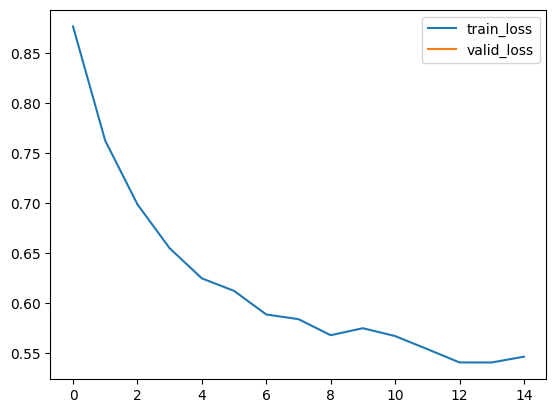

In [8]:
# train_lossとvalid_lossのプロット

plt.plot(grand_train_loss, label="train_loss")
plt.plot(grand_valid_loss, label="valid_loss")
plt.legend()
plt.show()

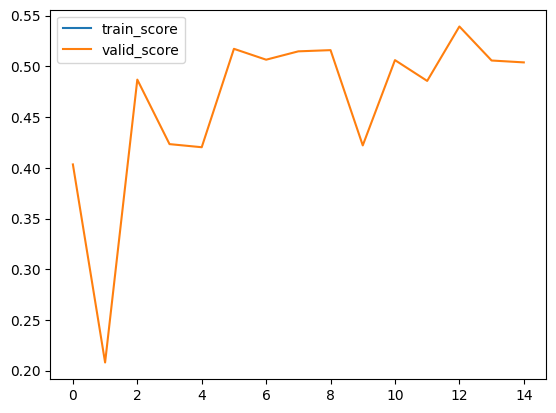

In [9]:
# train_scoreとvalid_scoreのプロット
plt.plot(grand_train_score, label="train_score")
plt.plot(grand_valid_score, label="valid_score")
plt.legend()
plt.show()

In [10]:
random.random()

0.053170780765320336